In [101]:
# Импорт необходимых библиотек
from sklearn.datasets import make_moons
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd # Добавим pandas для работы с CSV

In [102]:
# Функция для отображения на графике области принятия решения
def plot_2d_separator(classifier, X, fill=False, line=True, ax=None, eps=None):
    if eps is None:
        # Автоматический подбор отступов в зависимости от масштаба данных
        range_x = X[:, 0].max() - X[:, 0].min()
        range_y = X[:, 1].max() - X[:, 1].min()
        eps_x = range_x * 0.1
        eps_y = range_y * 0.1
    else:
        eps_x = eps_y = eps
    x_min, x_max = X[:, 0].min() - eps_x, X[:, 0].max() + eps_x
    y_min, y_max = X[:, 1].min() - eps_y, X[:, 1].max() + eps_y
    # Убедимся, что min < max
    if x_min == x_max:
        x_max += 1
    if y_min == y_max:
        y_max += 1
    xx = np.linspace(x_min, x_max, 100)
    yy = np.linspace(y_min, y_max, 100)
    x1, x2 = np.meshgrid(xx, yy)
    X_grid = np.c_[x1.ravel(), x2.ravel()]
    try:
        decision_values = classifier.decision_function(X_grid)
        levels = [0]
        fill_levels = [decision_values.min(), 0, decision_values.max()]
    except AttributeError:
        # Для классификаторов без decision_function используем predict_proba
        # Проверяем наличие метода predict_proba
        if hasattr(classifier, 'predict_proba'):
             # Берем вероятность класса 1
            decision_values = classifier.predict_proba(X_grid)[:, 1]
            levels = [.5]
            fill_levels = [0, .5, 1]
        else: # Если нет и predict_proba, используем predict
            decision_values = classifier.predict(X_grid)
            levels = [.5] # Граница между 0 и 1
            # Уровни для заливки: все что ниже 0.5, и все что выше
            fill_levels = [decision_values.min(), 0.5, decision_values.max()]
    if ax is None:
        ax = plt.gca()
    # Убедимся, что decision_values имеет правильную форму для contourf/contour
    Z = decision_values.reshape(x1.shape)
    if fill:
        ax.contourf(x1, x2, Z, levels=fill_levels, colors=['cyan', 'pink', 'yellow'], alpha=0.5)
    if line:
        ax.contour(x1, x2, Z, levels=levels, colors='black')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    # ax.set_xlabel("Признак 1") # Убрано для универсальности
    # ax.set_ylabel("Признак 2")

Координаты первых 15 точек (moons): 
[[ 0.83103915 -0.25874875]
 [ 1.18506381  0.92038714]
 [ 1.16402213 -0.45552558]
 [-0.0236556   1.08628844]
 [ 0.48050273  1.50942444]
 [ 1.31164912 -0.55117606]
 [ 1.16542367 -0.15862989]
 [ 0.1567364   1.31817168]
 [ 0.45330102  0.49607493]
 [ 1.65139719 -0.45980435]
 [ 1.02664982 -0.01569994]
 [-0.39967757  0.25219294]
 [ 1.8535271  -0.7164187 ]
 [ 0.11756474  0.62486933]
 [ 1.54123944 -0.51105069]]

Метки класса первых 15 точек (moons): 
[1 0 1 0 0 1 1 0 0 1 0 0 1 0 1]


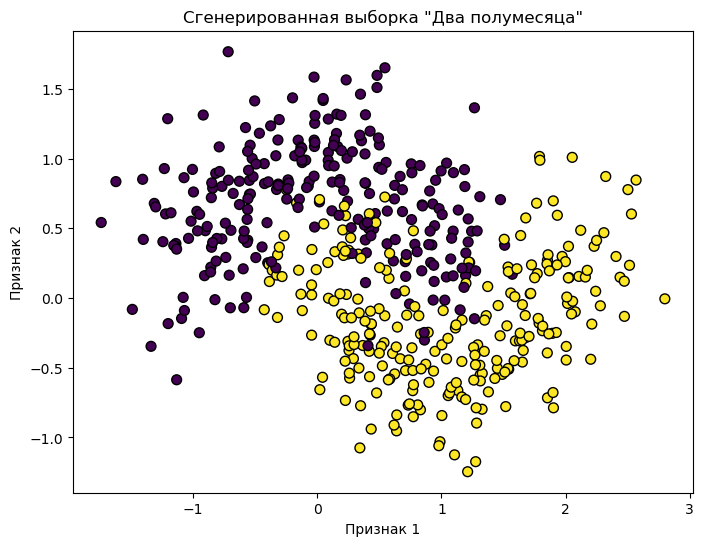

In [103]:
# Генерация выборки "два полумесяца"
# noise - уровень шума (разброс точек)
# random_state - для воспроизводимости результатов
X_moons, y_moons = make_moons(n_samples=500, noise=0.3, random_state=42) # Увеличим количество точек для наглядности

# Вывод первых 15 точек и их меток
print('Координаты первых 15 точек (moons): ')
print(X_moons[:15])
print('\nМетки класса первых 15 точек (moons): ')
print(y_moons[:15])

# Визуализация сгенерированной выборки
plt.figure(figsize=(8, 6))
plt.title('Сгенерированная выборка "Два полумесяца"')
plt.scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons, cmap='viridis', edgecolors='k', s=50)
plt.xlabel("Признак 1")
plt.ylabel("Признак 2")
plt.show()

--- k-NN с k=1 (moons) ---
Точность (Accuracy): 0.8533
ROC AUC: 0.8572
Матрица ошибок:
[[98  8]
 [25 94]]
--------------------



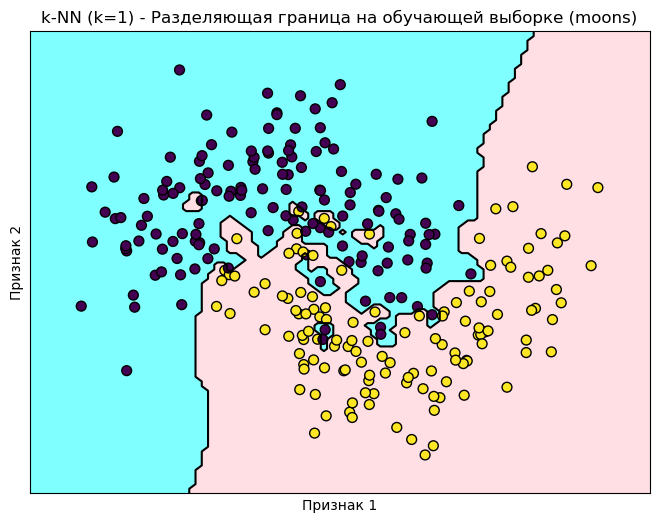

--- k-NN с k=3 (moons) ---
Точность (Accuracy): 0.8844
ROC AUC: 0.8887
Матрица ошибок:
[[102   4]
 [ 22  97]]
--------------------



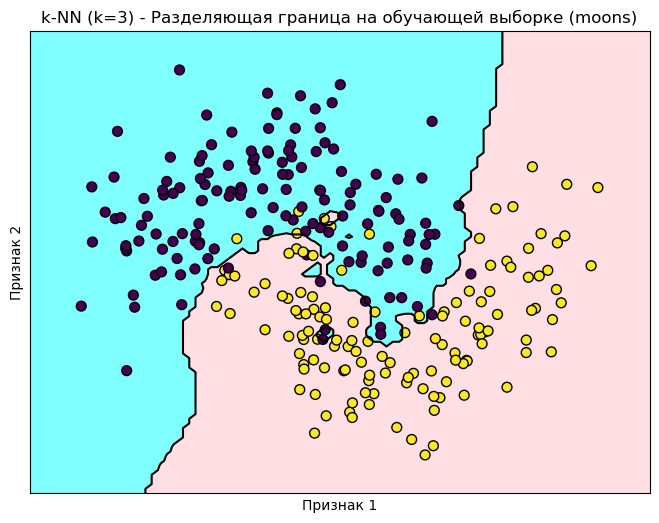

--- k-NN с k=5 (moons) ---
Точность (Accuracy): 0.9156
ROC AUC: 0.9197
Матрица ошибок:
[[105   1]
 [ 18 101]]
--------------------



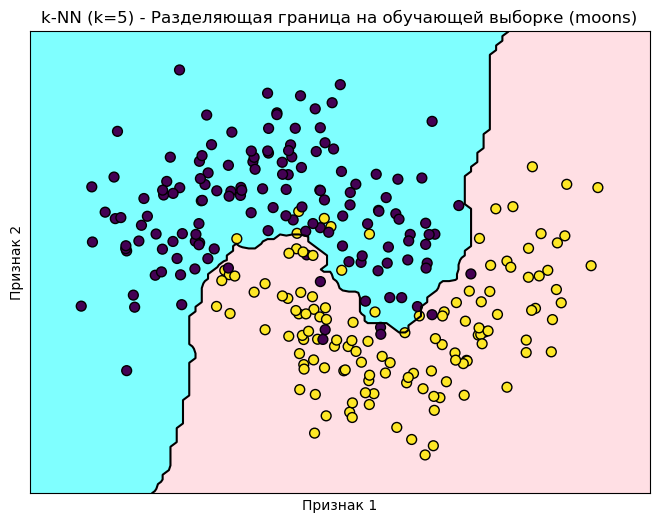

--- k-NN с k=9 (moons) ---
Точность (Accuracy): 0.9067
ROC AUC: 0.9102
Матрица ошибок:
[[103   3]
 [ 18 101]]
--------------------



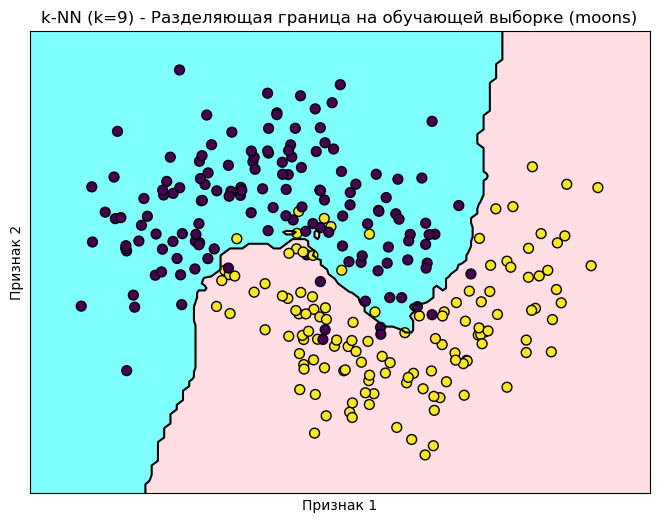

In [104]:
# Списки для хранения результатов
moons_results = []
amazon_results = []

# Список значений k для k-NN
neighbors = [1, 3, 5, 9]

for k in neighbors:
    # Создание и обучение модели k-NN
    knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    knn.fit(X_moons_train, y_moons_train)
    
    # Предсказание на тестовой выборке
    prediction = knn.predict(X_moons_test)
    
    # Оценка качества
    accuracy = accuracy_score(y_moons_test, prediction)
    roc_auc = roc_auc_score(y_moons_test, prediction)
    conf_matrix = confusion_matrix(y_moons_test, prediction)
    
    # Вывод результатов
    print(f"--- k-NN с k={k} (moons) ---")
    print(f"Точность (Accuracy): {accuracy:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print("Матрица ошибок:")
    print(conf_matrix)
    # print("\nПредсказание vs Реальность:")
    # print("Предсказание:", prediction)
    # print("Реальность:  ", y_test)
    print("-"*20 + "\n")

    moons_results.append({
        'method': 'k-NN',
        'params': f'k={k}',
        'accuracy': accuracy,
        'roc_auc': roc_auc,
        'conf_matrix': conf_matrix
    })
    
    # Визуализация разделяющей границы
    plt.figure(figsize=(8, 6))
    plot_2d_separator(knn, X_moons_train, fill=True, line=True)
    plt.scatter(X_moons_train[:, 0], X_moons_train[:, 1], c=y_moons_train, cmap='viridis', edgecolors='k', s=50)
    plt.title(f'k-NN (k={k}) - Разделяющая граница на обучающей выборке (moons)')
    plt.xlabel("Признак 1")
    plt.ylabel("Признак 2")
    plt.show()

--- Наивный Байесовский классификатор (moons) ---
Точность (Accuracy): 0.8444
ROC AUC: 0.8468
Матрица ошибок:
[[94 12]
 [23 96]]
--------------------



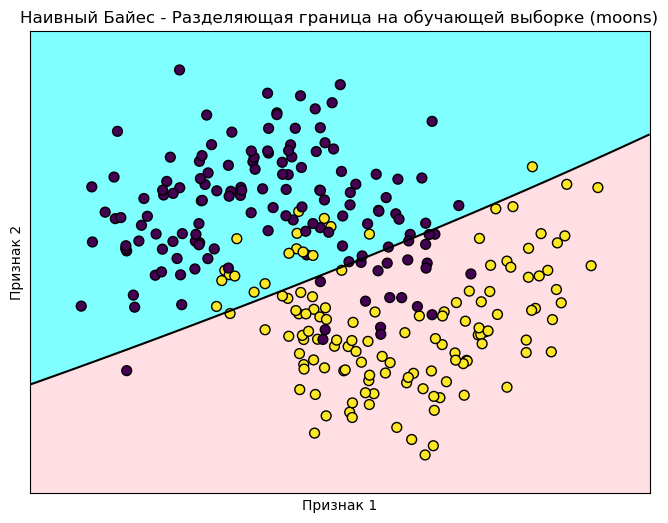

In [105]:
# Создание и обучение модели Наивного Байеса
nb = GaussianNB()
nb.fit(X_moons_train, y_moons_train)

# Предсказание на тестовой выборке
prediction_nb = nb.predict(X_moons_test)

# Оценка качества
accuracy_nb = accuracy_score(y_moons_test, prediction_nb)
roc_auc_nb = roc_auc_score(y_moons_test, prediction_nb)
conf_matrix_nb = confusion_matrix(y_moons_test, prediction_nb)

# Вывод результатов
print("--- Наивный Байесовский классификатор (moons) ---")
print(f"Точность (Accuracy): {accuracy_nb:.4f}")
print(f"ROC AUC: {roc_auc_nb:.4f}")
print("Матрица ошибок:")
print(conf_matrix_nb)
print("-"*20 + "\n")

moons_results.append({
    'method': 'Naive Bayes',
    'params': '',
    'accuracy': accuracy_nb,
    'roc_auc': roc_auc_nb,
    'conf_matrix': conf_matrix_nb
})

# Визуализация разделяющей границы
plt.figure(figsize=(8, 6))
plot_2d_separator(nb, X_moons_train, fill=True, line=True)
plt.scatter(X_moons_train[:, 0], X_moons_train[:, 1], c=y_moons_train, cmap='viridis', edgecolors='k', s=50)
plt.title('Наивный Байес - Разделяющая граница на обучающей выборке (moons)')
plt.xlabel("Признак 1")
plt.ylabel("Признак 2")
plt.show()

--- Случайный Лес с n_estimators=5 (moons) ---
Точность (Accuracy): 0.8800
ROC AUC: 0.8850
Матрица ошибок:
[[103   3]
 [ 24  95]]
--------------------



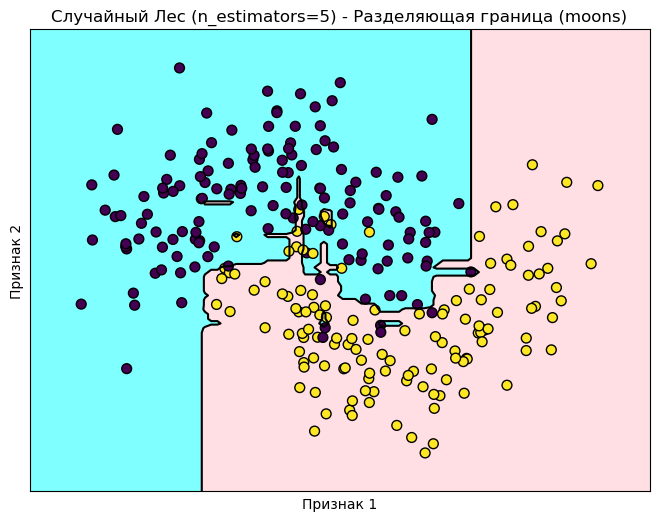

--- Случайный Лес с n_estimators=10 (moons) ---
Точность (Accuracy): 0.8711
ROC AUC: 0.8776
Матрица ошибок:
[[105   1]
 [ 28  91]]
--------------------



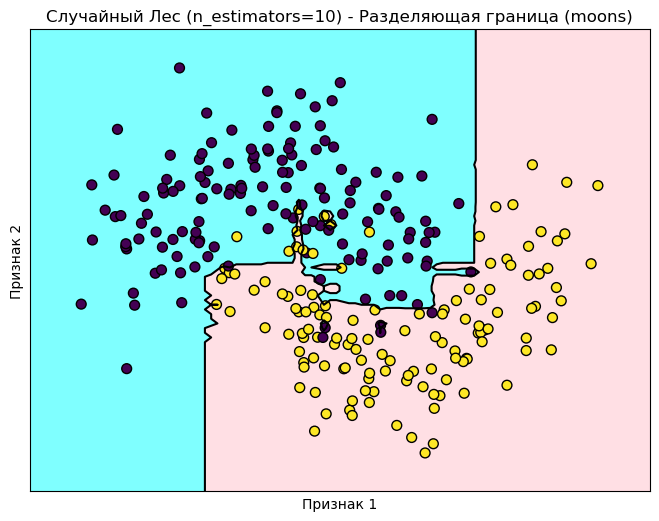

--- Случайный Лес с n_estimators=15 (moons) ---
Точность (Accuracy): 0.8756
ROC AUC: 0.8818
Матрица ошибок:
[[105   1]
 [ 27  92]]
--------------------



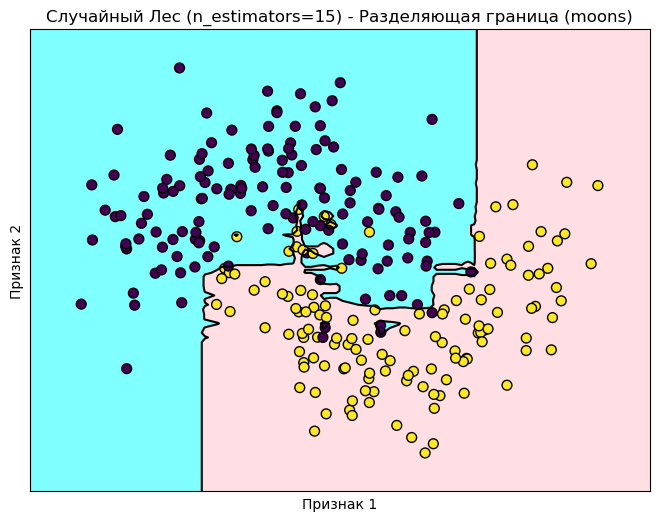

--- Случайный Лес с n_estimators=20 (moons) ---
Точность (Accuracy): 0.8800
ROC AUC: 0.8860
Матрица ошибок:
[[105   1]
 [ 26  93]]
--------------------



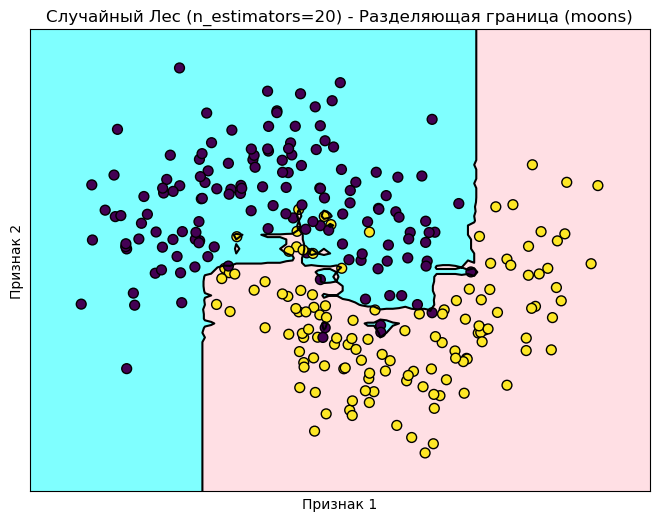

--- Случайный Лес с n_estimators=50 (moons) ---
Точность (Accuracy): 0.8889
ROC AUC: 0.8944
Матрица ошибок:
[[105   1]
 [ 24  95]]
--------------------



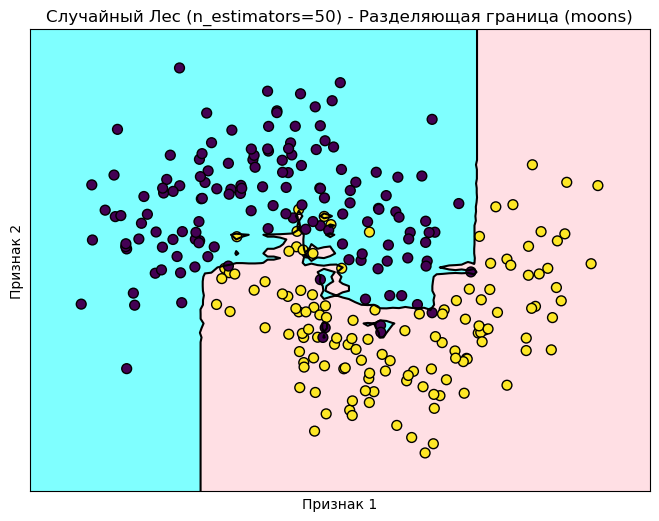

In [106]:
# Список значений n_estimators для Случайного Леса
estimators = [5, 10, 15, 20, 50]

for n in estimators:
    # Создание и обучение модели Случайного Леса
    # random_state для воспроизводимости
    rdf = RandomForestClassifier(n_estimators=n, random_state=42)
    rdf.fit(X_moons_train, y_moons_train)
    
    # Предсказание на тестовой выборке
    prediction_rdf = rdf.predict(X_moons_test)
    
    # Оценка качества
    accuracy_rdf = accuracy_score(y_moons_test, prediction_rdf)
    roc_auc_rdf = roc_auc_score(y_moons_test, prediction_rdf)
    conf_matrix_rdf = confusion_matrix(y_moons_test, prediction_rdf)
    
    # Вывод результатов
    print(f"--- Случайный Лес с n_estimators={n} (moons) ---")
    print(f"Точность (Accuracy): {accuracy_rdf:.4f}")
    print(f"ROC AUC: {roc_auc_rdf:.4f}")
    print("Матрица ошибок:")
    print(conf_matrix_rdf)
    print("-"*20 + "\n")

    moons_results.append({
        'method': 'Random Forest',
        'params': f'n_estimators={n}',
        'accuracy': accuracy_rdf,
        'roc_auc': roc_auc_rdf,
        'conf_matrix': conf_matrix_rdf
    })
    
    # Визуализация разделяющей границы
    plt.figure(figsize=(8, 6))
    plot_2d_separator(rdf, X_moons_train, fill=True, line=True)
    plt.scatter(X_moons_train[:, 0], X_moons_train[:, 1], c=y_moons_train, cmap='viridis', edgecolors='k', s=50)
    plt.title(f'Случайный Лес (n_estimators={n}) - Разделяющая граница (moons)')
    plt.xlabel("Признак 1")
    plt.ylabel("Признак 2")
    plt.show()

In [107]:
# Загрузка данных из CSV
file_path = 'amazon_sales_data 2025.csv'
try:
    amazon_data = pd.read_csv(file_path)
    print("Данные Amazon успешно загружены.")
    print("Первые 5 строк:")
    print(amazon_data.head())
    print("\nИнформация о данных:")
    amazon_data.info()
    print("\nУникальные значения в столбце 'Status':", amazon_data['Status'].unique())
except FileNotFoundError:
    print(f"Ошибка: Файл '{file_path}' не найден. Убедитесь, что он находится в той же папке, что и ноутбук.")
except Exception as e:
    print(f"Произошла ошибка при чтении файла: {e}")

# Предобработка:
# 1. Выбор признаков: 'Price' и 'Quantity'
# 2. Выбор целевой переменной: 'Status'
# 3. Фильтрация: Оставим только 'Completed' и 'Cancelled' для бинарной классификации
# 4. Кодирование целевой переменной: 'Completed' -> 1, 'Cancelled' -> 0

if 'amazon_data' in locals(): # Проверяем, загрузились ли данные
    # Фильтруем статусы
    amazon_data_filtered = amazon_data[amazon_data['Status'].isin(['Completed', 'Cancelled'])].copy() # Используем .copy() для избежания SettingWithCopyWarning
    
    # Выбираем признаки и цель
    features = ['Price', 'Quantity']
    target = 'Status'
    X_amazon = amazon_data_filtered[features].values
    y_amazon_str = amazon_data_filtered[target].values
    
    # Кодируем целевую переменную
    y_amazon = np.where(y_amazon_str == 'Completed', 1, 0)
    
    print(f"\nКоличество записей после фильтрации: {len(amazon_data_filtered)}")
    print(f"Количество 'Completed' (1): {sum(y_amazon == 1)}")
    print(f"Количество 'Cancelled' (0): {sum(y_amazon == 0)}")
    print("\nПризнаки (X_amazon) первые 5 строк:")
    print(X_amazon[:5])
    print("\nЦелевая переменная (y_amazon) первые 15 значений:")
    print(y_amazon[:15])

Данные Amazon успешно загружены.
Первые 5 строк:
  Order ID      Date        Product     Category  Price  Quantity  \
0  ORD0001  14-03-25  Running Shoes     Footwear     60         3   
1  ORD0002  20-03-25     Headphones  Electronics    100         4   
2  ORD0003  15-02-25  Running Shoes     Footwear     60         2   
3  ORD0004  19-02-25  Running Shoes     Footwear     60         3   
4  ORD0005  10-03-25     Smartwatch  Electronics    150         3   

   Total Sales  Customer Name Customer Location Payment Method     Status  
0          180     Emma Clark          New York     Debit Card  Cancelled  
1          400  Emily Johnson     San Francisco     Debit Card    Pending  
2          120       John Doe            Denver     Amazon Pay  Cancelled  
3          180  Olivia Wilson            Dallas    Credit Card    Pending  
4          450     Emma Clark          New York     Debit Card    Pending  

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entr

#### 6.2 Разделение данных Amazon

Размер обучающей выборки (Amazon): 132 точек
Размер тестовой выборки (Amazon): 33 точек


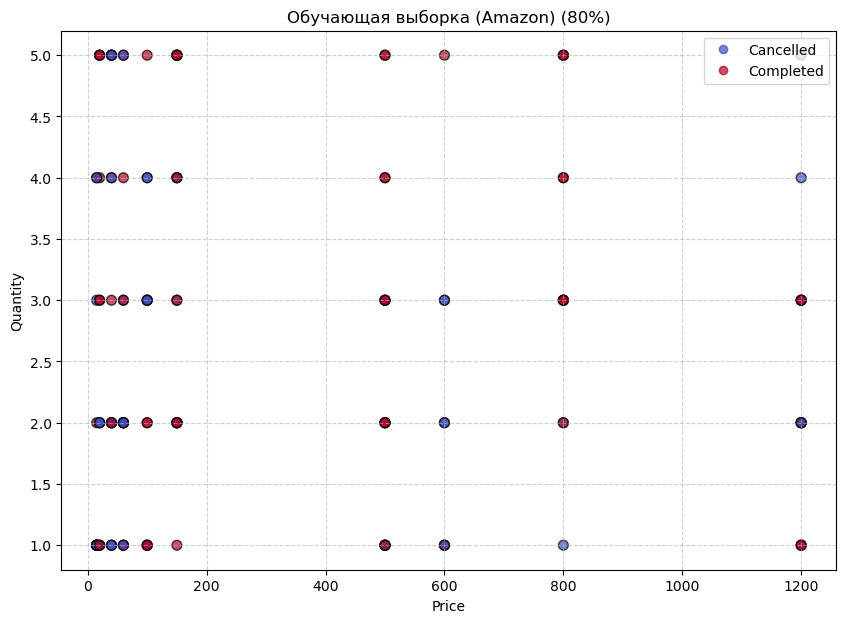

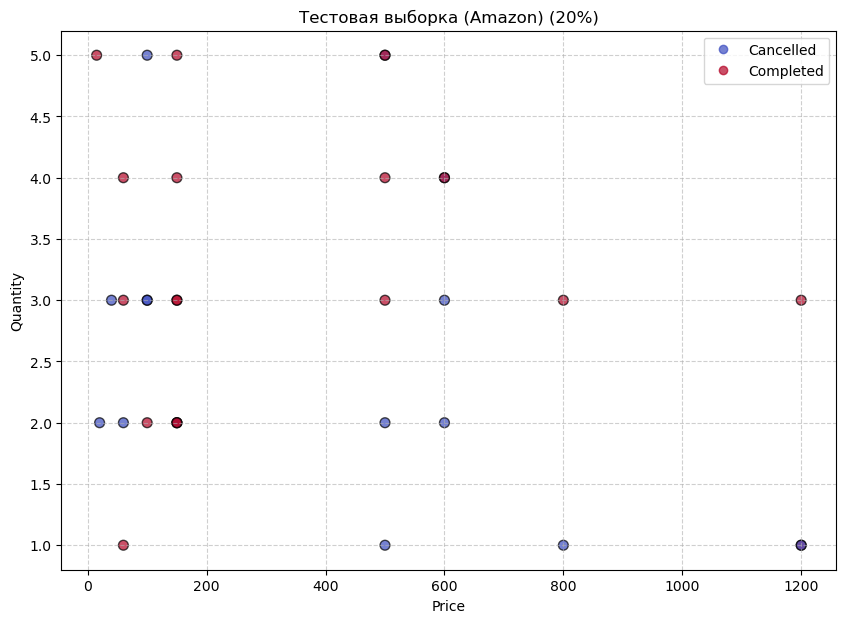

In [108]:
# Разделение данных Amazon на обучающую и тестовую выборки
if 'X_amazon' in locals() and 'y_amazon' in locals():
    test_fraction_amazon = 0.2 # Возьмем 20% для теста
    X_amazon_train, X_amazon_test, y_amazon_train, y_amazon_test = train_test_split(
        X_amazon, y_amazon, test_size=test_fraction_amazon, random_state=42, stratify=y_amazon # stratify для сохранения пропорций классов
    )
    
    print(f"Размер обучающей выборки (Amazon): {X_amazon_train.shape[0]} точек")
    print(f"Размер тестовой выборки (Amazon): {X_amazon_test.shape[0]} точек")
    
    # Визуализация обучающей выборки Amazon
    plt.figure(figsize=(10, 7))
    plt.title(f'Обучающая выборка (Amazon) ({100*(1-test_fraction_amazon):.0f}%)')
    scatter = plt.scatter(X_amazon_train[:, 0], X_amazon_train[:, 1], c=y_amazon_train, cmap='coolwarm', edgecolors='k', s=50, alpha=0.7)
    plt.xlabel("Price")
    plt.ylabel("Quantity")
    plt.legend(handles=scatter.legend_elements()[0], labels=['Cancelled', 'Completed'])
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()
    
    # Визуализация тестовой выборки Amazon
    plt.figure(figsize=(10, 7))
    plt.title(f'Тестовая выборка (Amazon) ({100*test_fraction_amazon:.0f}%)')
    scatter = plt.scatter(X_amazon_test[:, 0], X_amazon_test[:, 1], c=y_amazon_test, cmap='coolwarm', edgecolors='k', s=50, alpha=0.7)
    plt.xlabel("Price")
    plt.ylabel("Quantity")
    plt.legend(handles=scatter.legend_elements()[0], labels=['Cancelled', 'Completed'])
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()
else:
    print("Данные Amazon не были подготовлены. Проверьте предыдущую ячейку.")

--- k-NN с k=1 (Amazon) ---
Точность (Accuracy): 0.6364
ROC AUC: 0.6500
Матрица ошибок:
[[12  3]
 [ 9  9]]
--------------------



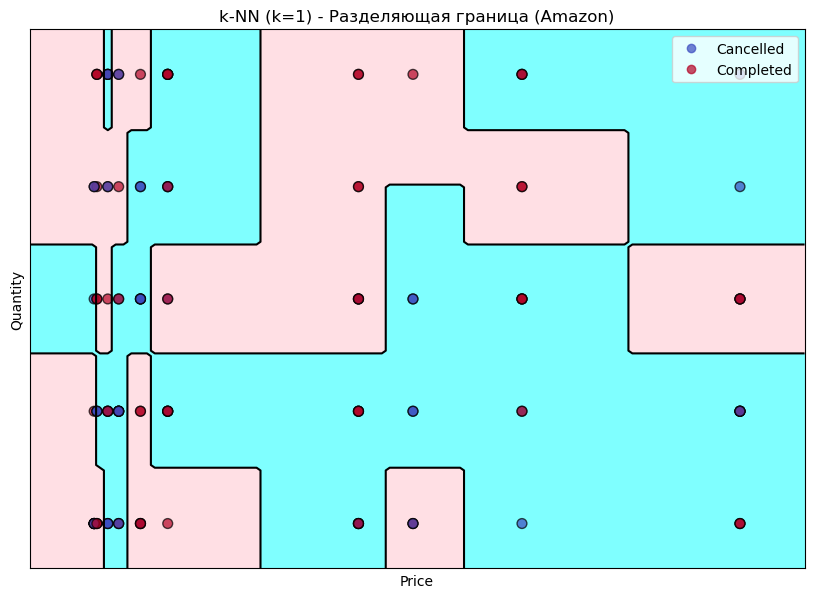

--- k-NN с k=3 (Amazon) ---
Точность (Accuracy): 0.5152
ROC AUC: 0.5278
Матрица ошибок:
[[10  5]
 [11  7]]
--------------------



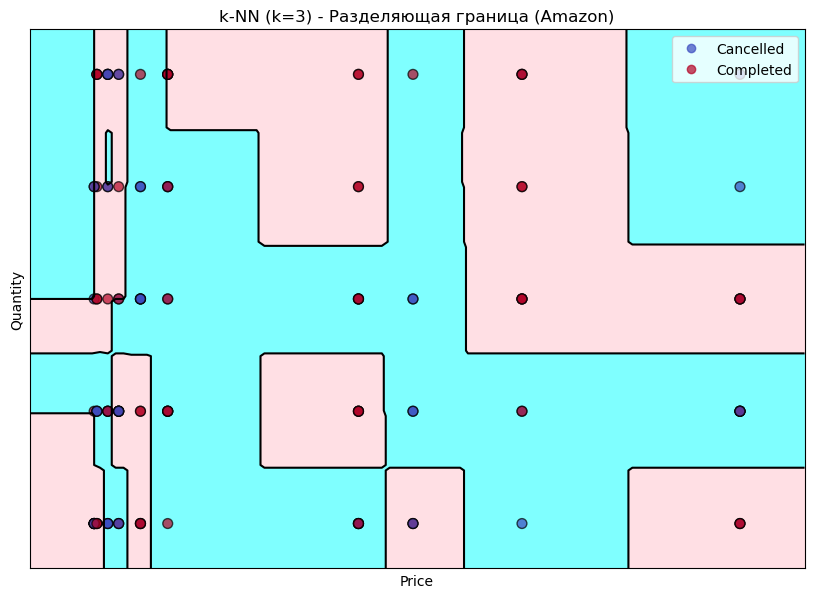

--- k-NN с k=5 (Amazon) ---
Точность (Accuracy): 0.5758
ROC AUC: 0.5833
Матрица ошибок:
[[10  5]
 [ 9  9]]
--------------------



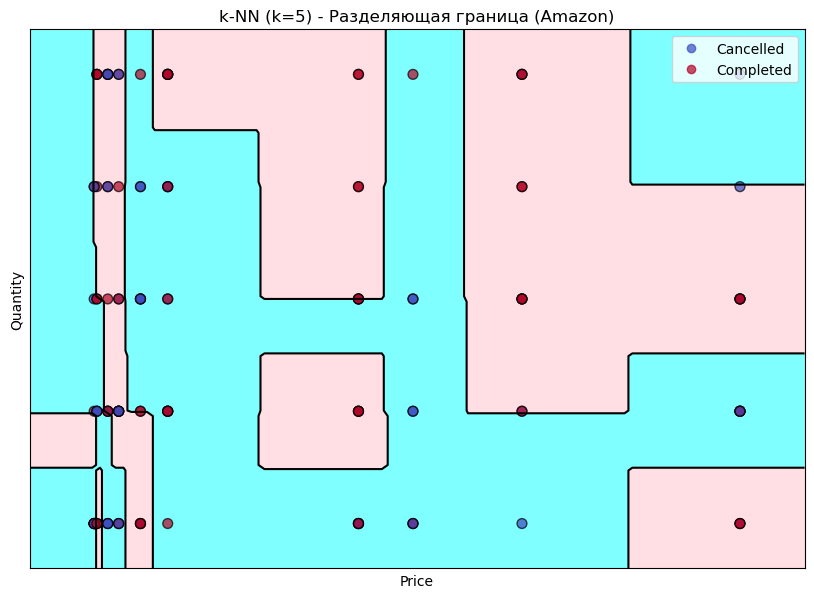

--- k-NN с k=9 (Amazon) ---
Точность (Accuracy): 0.5152
ROC AUC: 0.5167
Матрица ошибок:
[[8 7]
 [9 9]]
--------------------



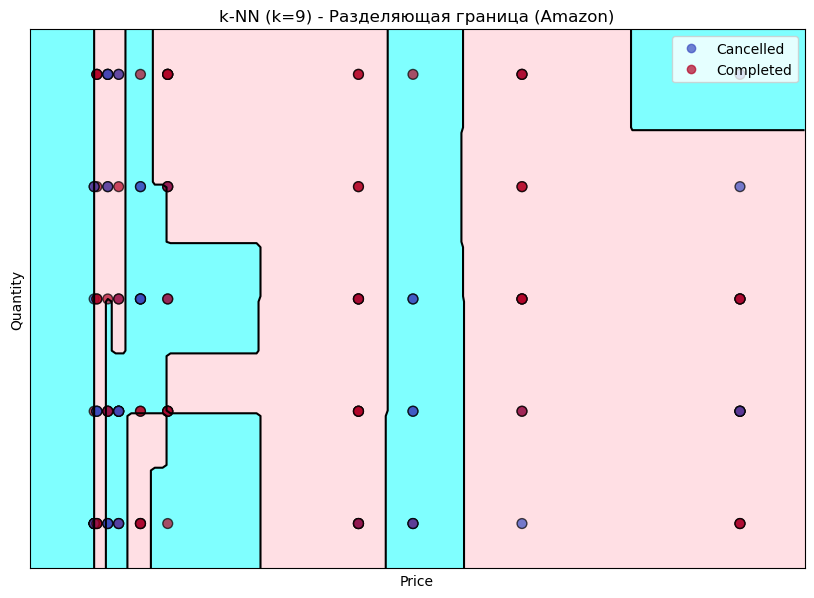

In [109]:
if 'X_amazon_train' in locals(): # Проверяем наличие данных
    neighbors_amazon = [1, 3, 5, 9]
    
    for k in neighbors_amazon:
        knn_amazon = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
        knn_amazon.fit(X_amazon_train, y_amazon_train)
        prediction_amazon = knn_amazon.predict(X_amazon_test)
        
        accuracy_amazon = accuracy_score(y_amazon_test, prediction_amazon)
        # Проверка на наличие обоих классов в y_test перед вычислением ROC AUC
        roc_auc_amazon = 'N/A' # Значение по умолчанию
        if len(np.unique(y_amazon_test)) > 1:
             try:
                 roc_auc_amazon = roc_auc_score(y_amazon_test, prediction_amazon)
                 roc_auc_amazon = f"{roc_auc_amazon:.4f}"
             except ValueError as e:
                 print(f"Не удалось вычислить ROC AUC для k={k}: {e}")
        else:
            print(f"ROC AUC не может быть вычислен для k={k}: только один класс в y_amazon_test.")
            
        conf_matrix_amazon = confusion_matrix(y_amazon_test, prediction_amazon)
        
        print(f"--- k-NN с k={k} (Amazon) ---")
        print(f"Точность (Accuracy): {accuracy_amazon:.4f}")
        print(f"ROC AUC: {roc_auc_amazon}")
        print("Матрица ошибок:")
        print(conf_matrix_amazon)
        print("-"*20 + "\n")

        amazon_results.append({
        'method': 'k-NN',
        'params': f'k={k}',
        'accuracy': accuracy_amazon,
        'roc_auc': roc_auc_amazon, # Уже содержит 'N/A' если нужно
        'conf_matrix': conf_matrix_amazon
        })
        
        # Визуализация
        plt.figure(figsize=(10, 7))
        plot_2d_separator(knn_amazon, X_amazon_train, fill=True, line=True)
        scatter = plt.scatter(X_amazon_train[:, 0], X_amazon_train[:, 1], c=y_amazon_train, cmap='coolwarm', edgecolors='k', s=50, alpha=0.7)
        plt.title(f'k-NN (k={k}) - Разделяющая граница (Amazon)')
        plt.xlabel("Price")
        plt.ylabel("Quantity")
        plt.legend(handles=scatter.legend_elements()[0], labels=['Cancelled', 'Completed'])
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()
else:
     print("Обучающие данные Amazon (X_amazon_train) не найдены. Выполните предыдущие ячейки.")

--- Наивный Байесовский классификатор (Amazon) ---
Точность (Accuracy): 0.6364
ROC AUC: 0.6278
Матрица ошибок:
[[ 8  7]
 [ 5 13]]
--------------------



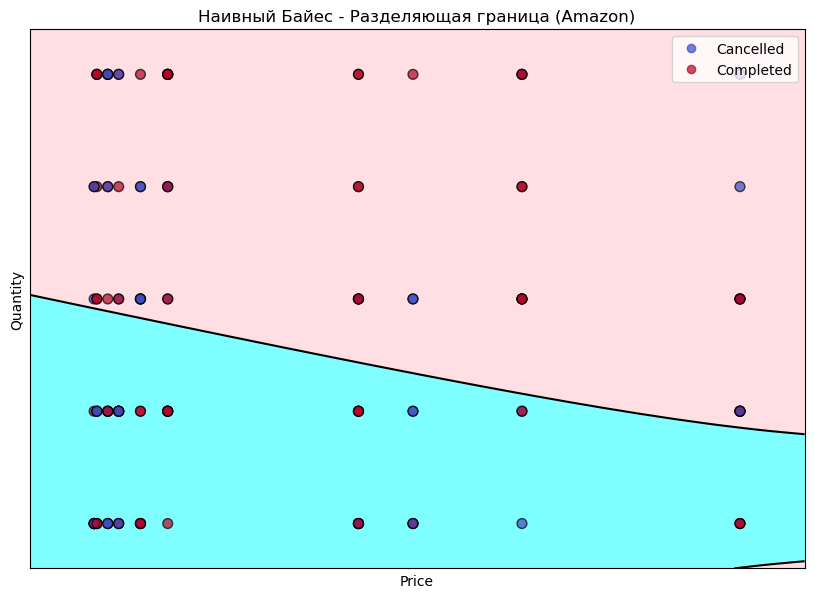

In [110]:
if 'X_amazon_train' in locals():
    nb_amazon = GaussianNB()
    nb_amazon.fit(X_amazon_train, y_amazon_train)
    prediction_nb_amazon = nb_amazon.predict(X_amazon_test)
    
    accuracy_nb_amazon = accuracy_score(y_amazon_test, prediction_nb_amazon)
    roc_auc_nb_amazon = 'N/A'
    if len(np.unique(y_amazon_test)) > 1:
        try:
            roc_auc_nb_amazon = roc_auc_score(y_amazon_test, prediction_nb_amazon)
            roc_auc_nb_amazon = f"{roc_auc_nb_amazon:.4f}"
        except ValueError as e:
            print(f"Не удалось вычислить ROC AUC для Наивного Байеса: {e}")
    else:
         print(f"ROC AUC не может быть вычислен для Наивного Байеса: только один класс в y_amazon_test.")
         
    conf_matrix_nb_amazon = confusion_matrix(y_amazon_test, prediction_nb_amazon)
    
    print("--- Наивный Байесовский классификатор (Amazon) ---")
    print(f"Точность (Accuracy): {accuracy_nb_amazon:.4f}")
    print(f"ROC AUC: {roc_auc_nb_amazon}")
    print("Матрица ошибок:")
    print(conf_matrix_nb_amazon)
    print("-"*20 + "\n")

    amazon_results.append({
        'method': 'Naive Bayes',
        'params': '',
        'accuracy': accuracy_nb_amazon,
        'roc_auc': roc_auc_nb_amazon, # Уже содержит 'N/A' если нужно
        'conf_matrix': conf_matrix_nb_amazon
    })
    
    # Визуализация
    plt.figure(figsize=(10, 7))
    plot_2d_separator(nb_amazon, X_amazon_train, fill=True, line=True)
    scatter = plt.scatter(X_amazon_train[:, 0], X_amazon_train[:, 1], c=y_amazon_train, cmap='coolwarm', edgecolors='k', s=50, alpha=0.7)
    plt.title('Наивный Байес - Разделяющая граница (Amazon)')
    plt.xlabel("Price")
    plt.ylabel("Quantity")
    plt.legend(handles=scatter.legend_elements()[0], labels=['Cancelled', 'Completed'])
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()
else:
     print("Обучающие данные Amazon (X_amazon_train) не найдены. Выполните предыдущие ячейки.")

--- Случайный Лес с n_estimators=5 (Amazon) ---
Точность (Accuracy): 0.6061
ROC AUC: 0.6056
Матрица ошибок:
[[ 9  6]
 [ 7 11]]
--------------------



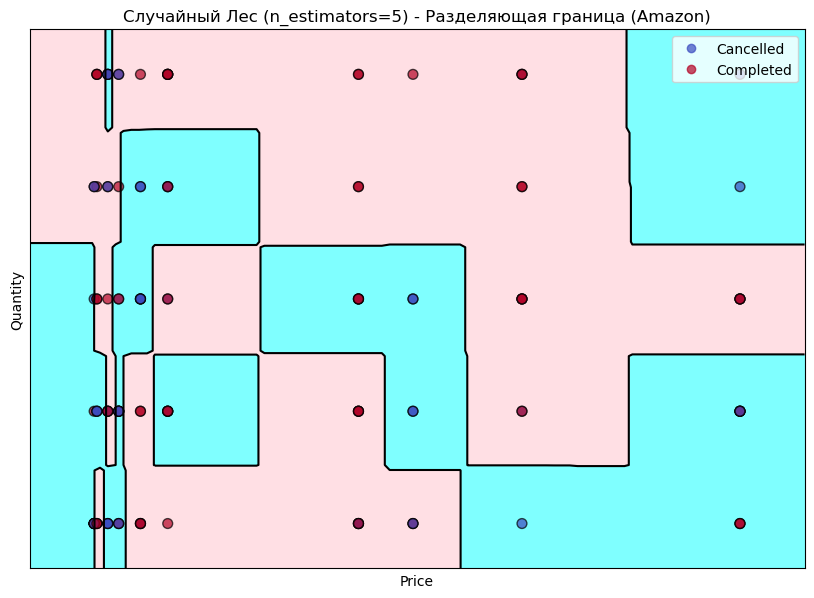

--- Случайный Лес с n_estimators=10 (Amazon) ---
Точность (Accuracy): 0.6061
ROC AUC: 0.6111
Матрица ошибок:
[[10  5]
 [ 8 10]]
--------------------



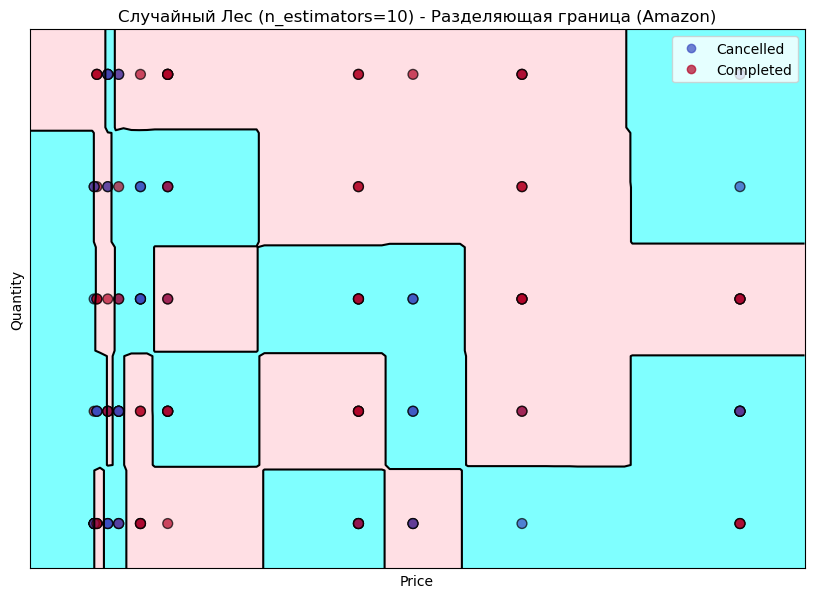

--- Случайный Лес с n_estimators=15 (Amazon) ---
Точность (Accuracy): 0.6364
ROC AUC: 0.6278
Матрица ошибок:
[[ 8  7]
 [ 5 13]]
--------------------



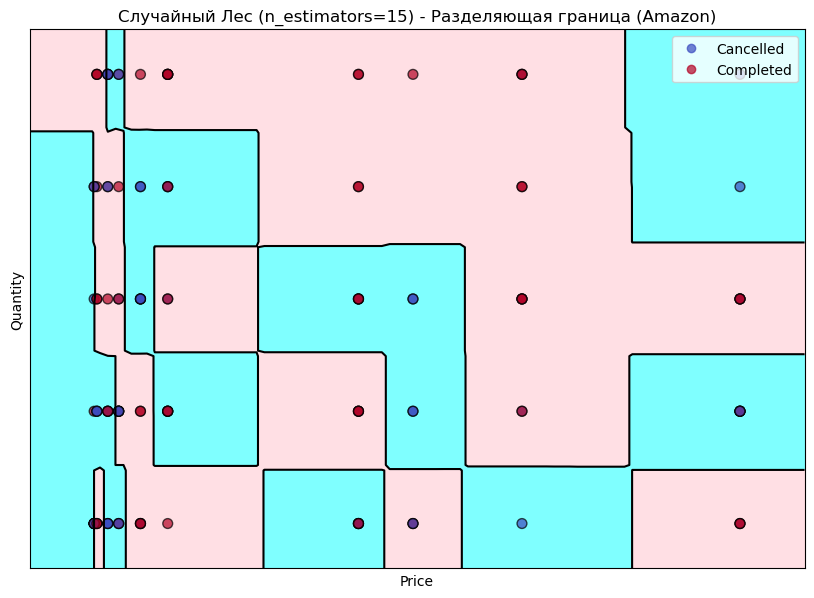

--- Случайный Лес с n_estimators=20 (Amazon) ---
Точность (Accuracy): 0.6364
ROC AUC: 0.6278
Матрица ошибок:
[[ 8  7]
 [ 5 13]]
--------------------



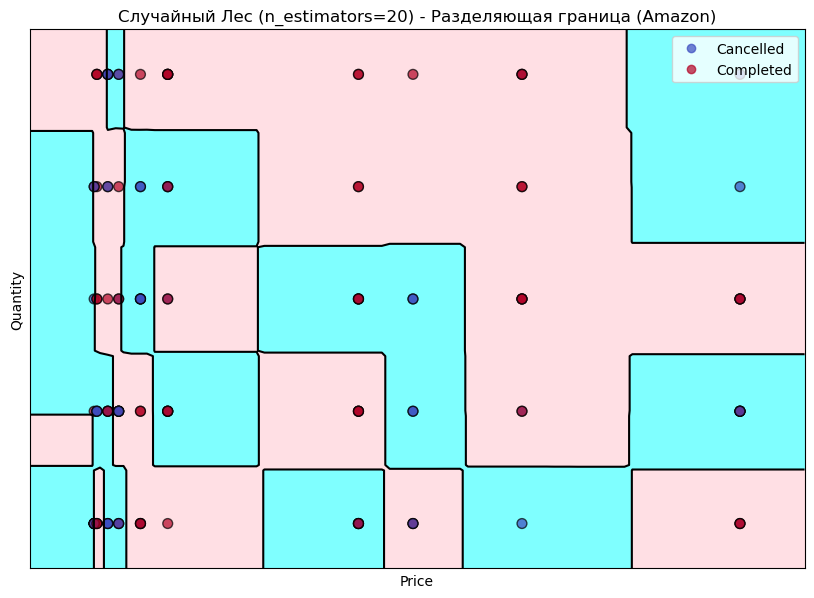

--- Случайный Лес с n_estimators=50 (Amazon) ---
Точность (Accuracy): 0.6667
ROC AUC: 0.6611
Матрица ошибок:
[[ 9  6]
 [ 5 13]]
--------------------



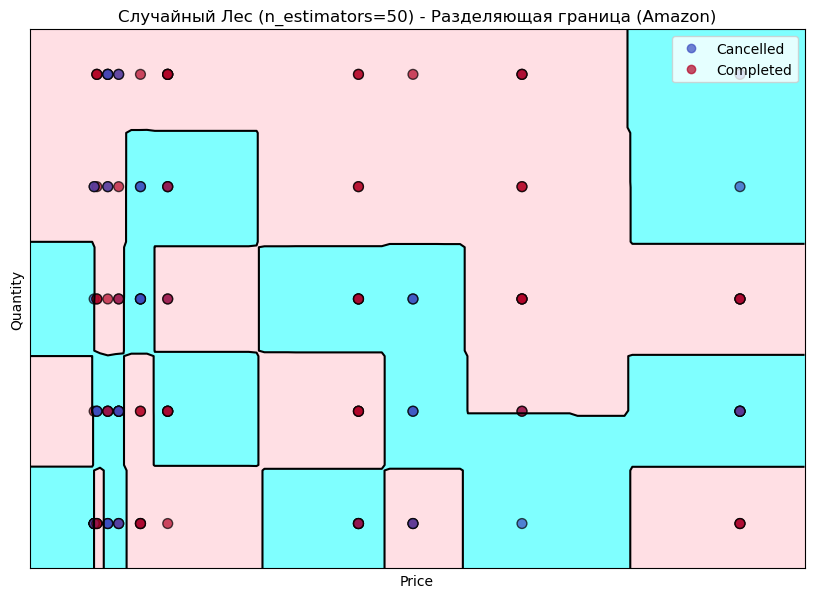

In [111]:
if 'X_amazon_train' in locals():
    estimators_amazon = [5, 10, 15, 20, 50]
    
    for n in estimators_amazon:
        rdf_amazon = RandomForestClassifier(n_estimators=n, random_state=42)
        rdf_amazon.fit(X_amazon_train, y_amazon_train)
        prediction_rdf_amazon = rdf_amazon.predict(X_amazon_test)
        
        accuracy_rdf_amazon = accuracy_score(y_amazon_test, prediction_rdf_amazon)
        roc_auc_rdf_amazon = 'N/A'
        if len(np.unique(y_amazon_test)) > 1:
            try:
                roc_auc_rdf_amazon = roc_auc_score(y_amazon_test, prediction_rdf_amazon)
                roc_auc_rdf_amazon = f"{roc_auc_rdf_amazon:.4f}"
            except ValueError as e:
                 print(f"Не удалось вычислить ROC AUC для Случайного Леса (n={n}): {e}")
        else:
            print(f"ROC AUC не может быть вычислен для Случайного Леса (n={n}): только один класс в y_amazon_test.")
            
        conf_matrix_rdf_amazon = confusion_matrix(y_amazon_test, prediction_rdf_amazon)
        
        print(f"--- Случайный Лес с n_estimators={n} (Amazon) ---")
        print(f"Точность (Accuracy): {accuracy_rdf_amazon:.4f}")
        print(f"ROC AUC: {roc_auc_rdf_amazon}")
        print("Матрица ошибок:")
        print(conf_matrix_rdf_amazon)
        print("-"*20 + "\n")
        
        amazon_results.append({
        'method': 'Random Forest',
        'params': f'n_estimators={n}',
        'accuracy': accuracy_rdf_amazon,
        'roc_auc': roc_auc_rdf_amazon, # Уже содержит 'N/A' если нужно
        'conf_matrix': conf_matrix_rdf_amazon
        })

        # Визуализация
        plt.figure(figsize=(10, 7))
        plot_2d_separator(rdf_amazon, X_amazon_train, fill=True, line=True)
        scatter = plt.scatter(X_amazon_train[:, 0], X_amazon_train[:, 1], c=y_amazon_train, cmap='coolwarm', edgecolors='k', s=50, alpha=0.7)
        plt.title(f'Случайный Лес (n_estimators={n}) - Разделяющая граница (Amazon)')
        plt.xlabel("Price")
        plt.ylabel("Quantity")
        plt.legend(handles=scatter.legend_elements()[0], labels=['Cancelled', 'Completed'])
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()
else:
     print("Обучающие данные Amazon (X_amazon_train) не найдены. Выполните предыдущие ячейки.")

In [112]:
### 8. Сводный отчет по результатам

print("# Общий отчет по результатам классификации\n")

print("## Данные \"Два полумесяца\" (Moons)\n")
if not moons_results:
    print("Результаты для 'Moons' отсутствуют.")
else:
    for res in moons_results:
        print(f"--- {res['method']} с {res['params']} (moons) ---")
        print(f"Точность (Accuracy): {res['accuracy']:.4f}")
        # Проверка типа roc_auc перед форматированием
        roc_auc_str = f"{res['roc_auc']:.4f}" if isinstance(res['roc_auc'], (int, float)) else str(res['roc_auc'])
        print(f"ROC AUC: {roc_auc_str}")
        print("Матрица ошибок:")
        # Форматирование матрицы ошибок
        cm_str = np.array2string(res['conf_matrix'], separator=' ')
        print(cm_str)
        print("-" * 20 + "\n")

print("\n## Данные \"Amazon Sales\"\n")
if not amazon_results:
    print("Результаты для 'Amazon' отсутствуют.")
else:
    for res in amazon_results:
        print(f"--- {res['method']} с {res['params']} (Amazon) ---")
        print(f"Точность (Accuracy): {res['accuracy']:.4f}")
        # ROC AUC уже строка 'N/A' или отформатированное число из предыдущих шагов
        print(f"ROC AUC: {res['roc_auc']}")
        print("Матрица ошибок:")
        # Форматирование матрицы ошибок
        cm_str = np.array2string(res['conf_matrix'], separator=' ')
        print(cm_str)
        print("-" * 20 + "\n")

# Общий отчет по результатам классификации

## Данные "Два полумесяца" (Moons)

--- k-NN с k=1 (moons) ---
Точность (Accuracy): 0.8533
ROC AUC: 0.8572
Матрица ошибок:
[[98  8]
 [25 94]]
--------------------

--- k-NN с k=3 (moons) ---
Точность (Accuracy): 0.8844
ROC AUC: 0.8887
Матрица ошибок:
[[102   4]
 [ 22  97]]
--------------------

--- k-NN с k=5 (moons) ---
Точность (Accuracy): 0.9156
ROC AUC: 0.9197
Матрица ошибок:
[[105   1]
 [ 18 101]]
--------------------

--- k-NN с k=9 (moons) ---
Точность (Accuracy): 0.9067
ROC AUC: 0.9102
Матрица ошибок:
[[103   3]
 [ 18 101]]
--------------------

--- Naive Bayes с  (moons) ---
Точность (Accuracy): 0.8444
ROC AUC: 0.8468
Матрица ошибок:
[[94 12]
 [23 96]]
--------------------

--- Random Forest с n_estimators=5 (moons) ---
Точность (Accuracy): 0.8800
ROC AUC: 0.8850
Матрица ошибок:
[[103   3]
 [ 24  95]]
--------------------

--- Random Forest с n_estimators=10 (moons) ---
Точность (Accuracy): 0.8711
ROC AUC: 0.8776
Матрица ошибок:
[[10